<a href="https://colab.research.google.com/github/ChengLongHang/Purchasing-Power-Parity-Implied-Exchange-Rate-Model/blob/main/PPP_Implied_Rate_Reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fredapi scikit-optimize pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from fredapi import Fred
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import scipy.stats as stats

# Real Exchange Rate Reversion Theory


In [3]:
# Initialize FRED API
fred = Fred(api_key='f9eb9107ffbd44e9a0fa4198db7978cf')

# Define data series IDs and start/end dates
series_id_inflaton = {
    'Inflation USA': 'CORESTICKM159SFRBATL'}

series_ids_CPI = {
    'Inflation CN': 'CHNCPIALLMINMEI',
    'Inflation KR': 'KORCPIALLMINMEI',
    'Inflation BR': 'BRACPIALLMINMEI',
    'Inflation UK': 'GBRCPIALLMINMEI',
    'Inflation MX': 'MEXCPIALLMINMEI',
    'Inflation IN': 'INDCPIALLMINMEI',
    'Inflation JP': 'JPNCPIALLMINMEI',
    'Inflation SA': 'ZAFCPIALLMINMEI',
    'Inflation ID': 'IDNCPIALLMINMEI',
    'Inflation SZ': 'CHECPIALLMINMEI',
    'Inflation SWE': 'SWECPIALLMINMEI'
}

start_date = '1999-01-01'
end_date = '2015-01-01'

In [4]:
# Get CPI data from FRED
cpi_data = pd.DataFrame()
for country, series_id in series_ids_CPI.items():
        data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
        cpi_data[country] = data

# Calculate inflation rate using log difference
inflation_data = np.log(cpi_data) - np.log(cpi_data.shift(12))
inflation_data = inflation_data.dropna() * 100

# Fetch inflation data for US and KR
inflation_rates = pd.DataFrame()
for country, series_id in series_id_inflaton.items():
        data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
        inflation_rates[country] = data

inflation_rates = inflation_rates.loc[inflation_data.index]

#Combine the dataframes
inflation_table = pd.concat([inflation_rates, inflation_data], axis=1)
inflation_table

,Inflation USA,Inflation CN,Inflation KR,Inflation BR,Inflation UK,Inflation MX,Inflation IN,Inflation JP,Inflation SA,Inflation ID,Inflation SZ,Inflation SWE
2000-01-01,2.335519,-0.200190,1.873141,8.482898,1.108045,10.456884,2.585331,-0.716106,2.613853,0.289229,1.572969,0.447037
2000-02-01,2.379221,0.697548,1.755222,7.568315,1.243969,10.005056,3.550673,-0.616026,2.303779,-0.900130,1.610653,0.926926
2000-03-01,2.483286,-0.200191,2.089595,6.694169,0.963531,9.633148,4.717852,-0.512563,3.333640,-1.172086,1.472045,1.027232
2000-04-01,2.409239,-0.300453,1.434275,6.555115,0.959569,9.286962,5.394035,-0.817208,4.445180,0.057691,1.392740,0.717825
2000-05-01,2.558647,0.099946,1.097469,6.265207,0.956945,9.060323,4.890387,-0.714694,4.954570,1.188649,1.568169,1.003918
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-01,1.950170,1.598276,1.139926,6.528648,1.308524,4.131072,6.111875,3.197828,5.888270,4.434399,-0.087668,-0.381656
2014-10-01,2.001463,1.497917,1.143394,6.379361,1.307208,4.207964,4.859252,2.788006,5.732231,4.715282,-0.012741,-0.120966
2014-11-01,1.999148,1.294550,0.960832,6.349387,1.107208,4.083357,4.032793,2.482041,5.584834,6.042554,-0.058675,-0.203853
2014-12-01,1.961226,1.399853,0.829978,6.210559,0.703167,4.000231,5.692588,2.377370,5.298303,8.028091,-0.328940,-0.314796


In [5]:
# List of countries (assuming they are columns in the inflation_table)
countries = ['CN', 'KR', 'BR', 'UK', 'MX', 'IN', 'JP', 'SA', 'ID', 'SZ', 'SWE']

# Dynamically calculate PPP for each country
for country in countries:
    inflation_table[f'PPP {country}'] = (
        (1 + inflation_table['Inflation USA'] / 100) /
        (1 + inflation_table[f'Inflation {country}'] / 100)
    )

In [6]:
# Define currency pairs for each country
currency_pairs = {
    'CN': 'USDCNY=X',
    'KR': 'USDKRW=X',
    'BR': 'USDBRL=X',
    'UK': 'USDGBP=X',
    'MX': 'USDMXN=X',
    'IN': 'USDINR=X',
    'JP': 'USDJPY=X',
    'SA': 'USDZAR=X',
    'ID': 'USDINR=X',
    'SZ': 'USDCHF=X',
    'SWE': 'USDSEK=X'
}

# Fetch exchange rate data for each currency pair
exchange_rates = {}
for country, pair in currency_pairs.items():
    data = yf.download(pair, start=inflation_table.index.min(), end=inflation_table.index.max())['Close']
    exchange_rates[country] = data

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['USDCNY=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['USDKRW=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['USDBRL=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['USDGBP=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['USDMXN=X']: YFRateLimitError('Too Many Requests. Rate limit

In [ ]:
# Find common dates for all currencies
common_dates = inflation_table.index
for country in currency_pairs:
    common_dates = common_dates.intersection(exchange_rates[country].index)

# Normalize the shape of the datasets
inflation_table_normalized = inflation_table.loc[common_dates]
exchange_rates_normalized = {}
for country, data in exchange_rates.items():
    exchange_rates_normalized[country] = data.loc[common_dates]

print(common_dates)

DatetimeIndex(['2003-12-01', '2004-03-01', '2004-04-01', '2004-06-01',
               '2004-07-01', '2006-06-01', '2006-08-01', '2006-09-01',
               '2006-11-01', '2006-12-01', '2007-01-01', '2007-02-01',
               '2007-03-01', '2007-05-01', '2007-06-01', '2007-08-01',
               '2007-10-01', '2007-11-01', '2008-01-01', '2008-02-01',
               '2008-09-01', '2008-10-01', '2008-12-01', '2009-01-01',
               '2009-04-01', '2009-05-01', '2009-07-01', '2009-09-01',
               '2009-10-01', '2009-12-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-06-01', '2010-07-01', '2010-09-01',
               '2010-10-01', '2010-11-01', '2010-12-01', '2011-02-01',
               '2011-03-01', '2011-04-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-11-01', '2011-12-01',
               '2012-02-01', '2012-03-01', '2012-05-01', '2012-06-01',
               '2012-08-01', '2012-10-01', '2012-11-01', '2013-01-01',
      

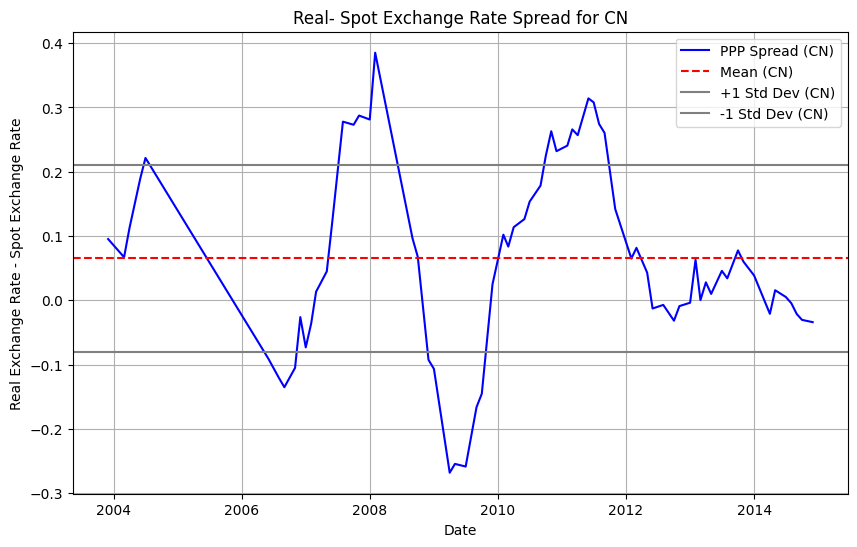

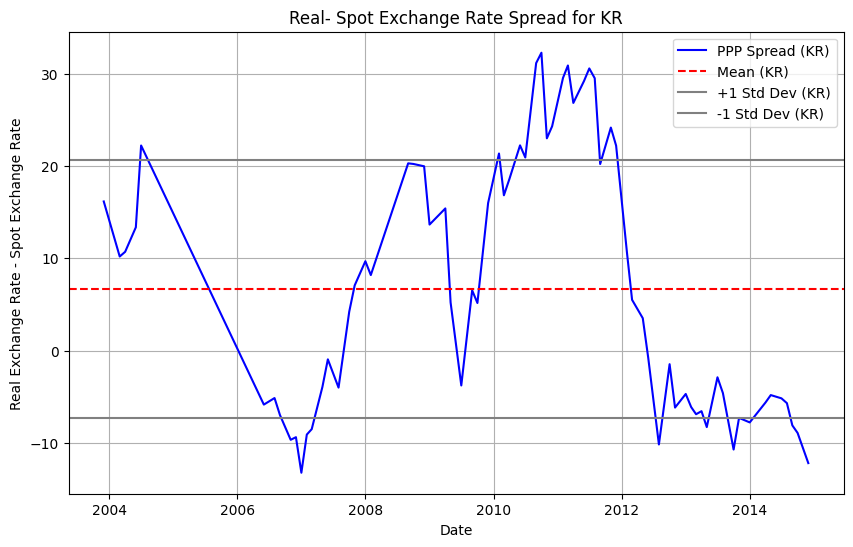

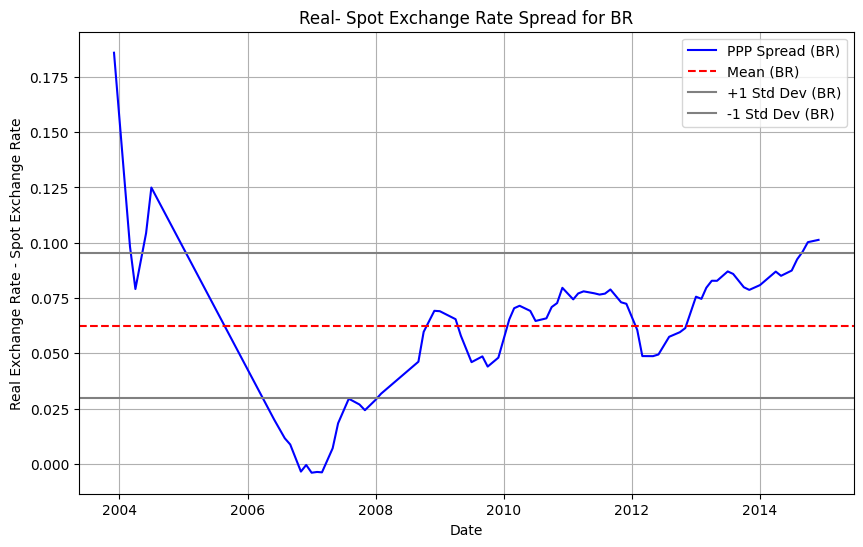

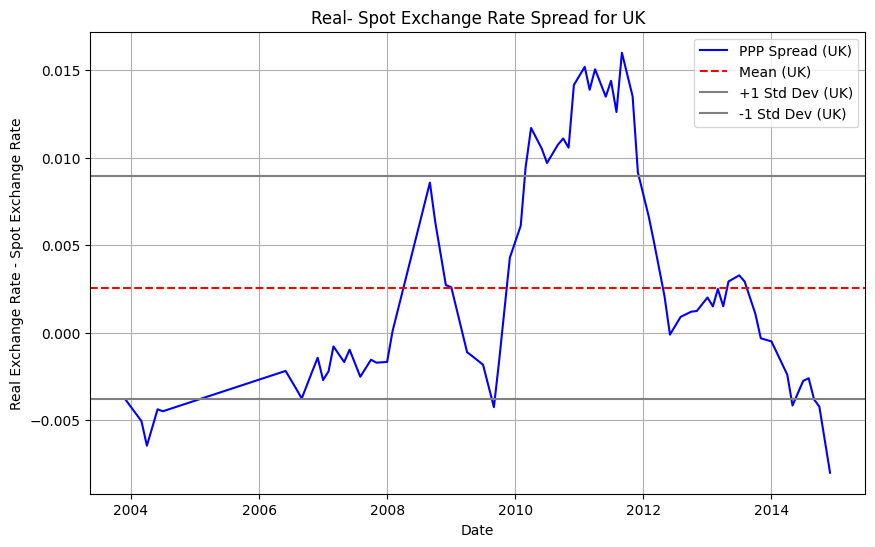

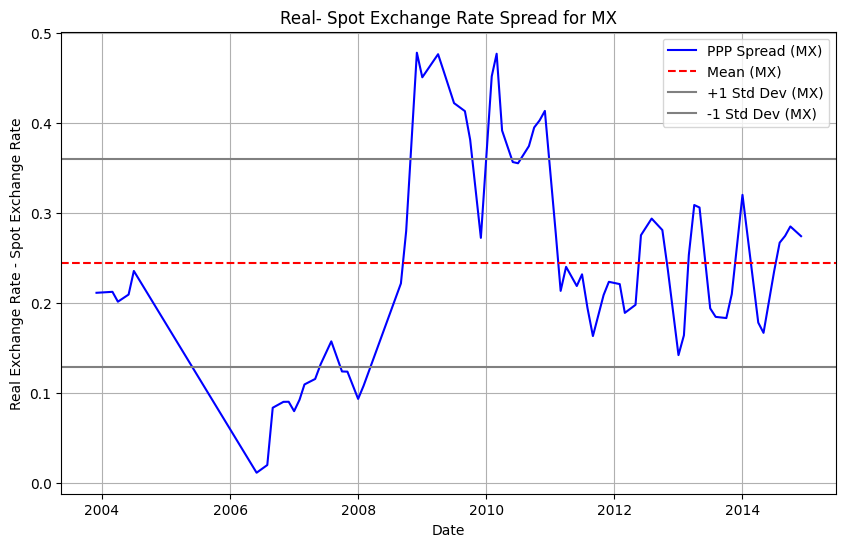

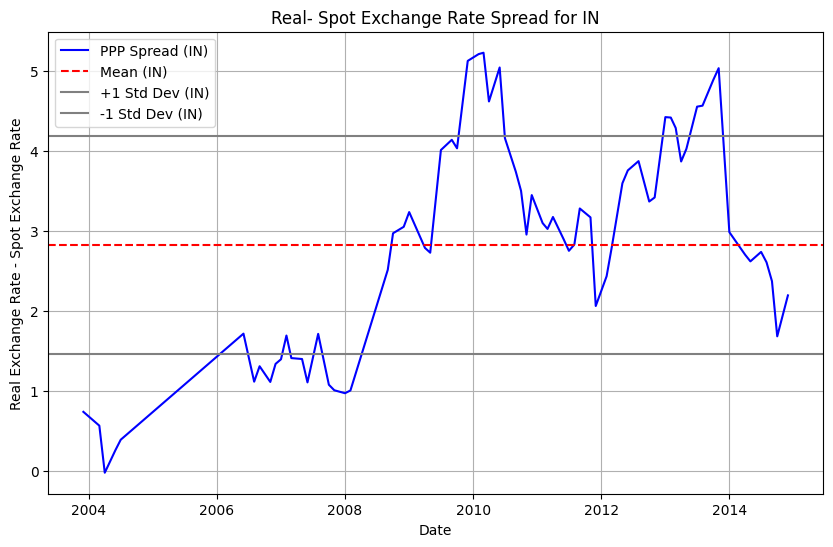

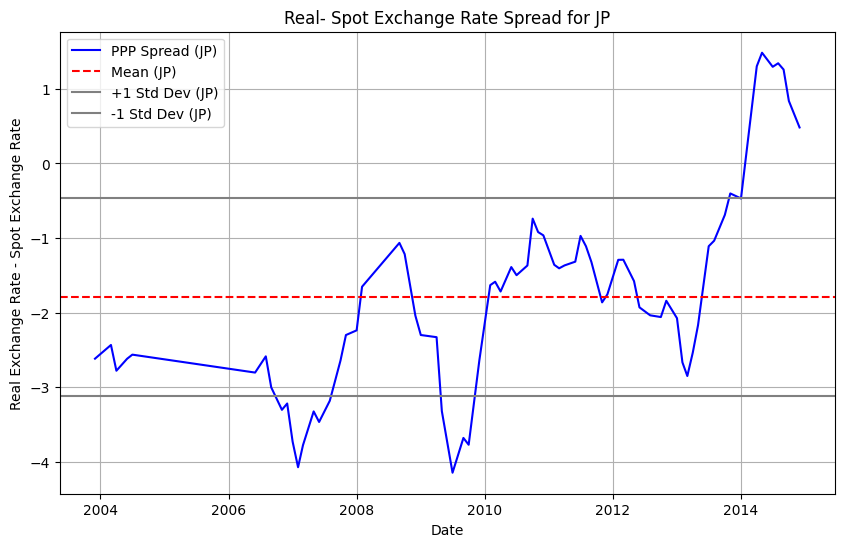

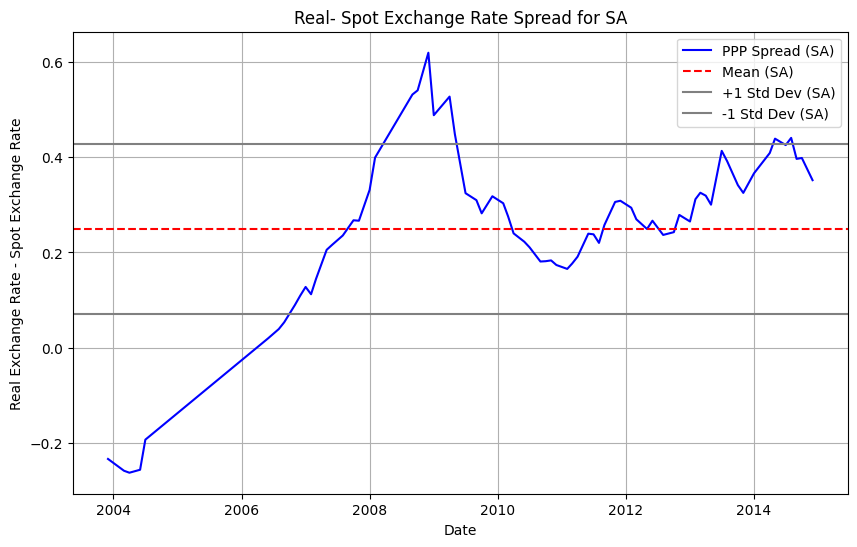

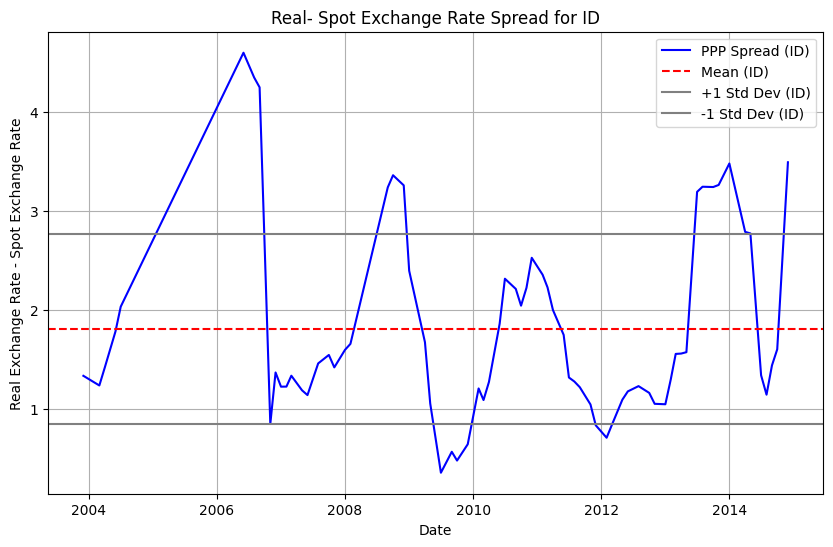

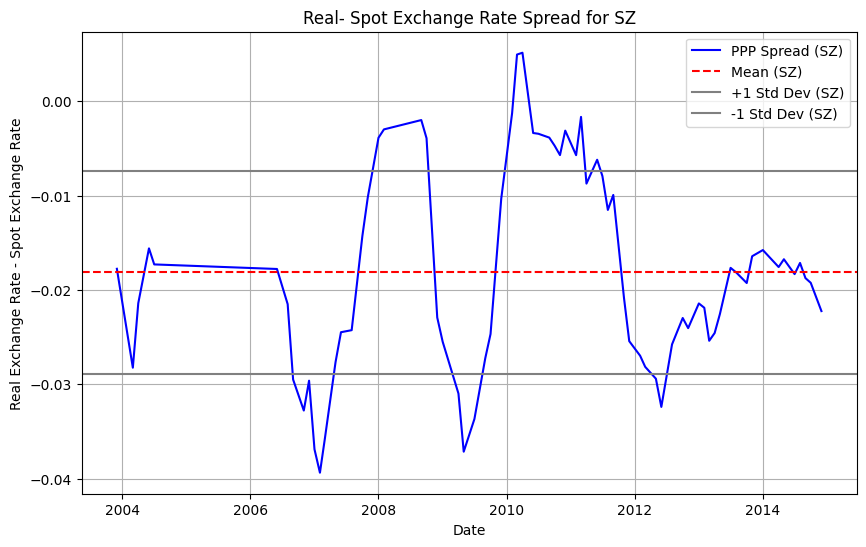

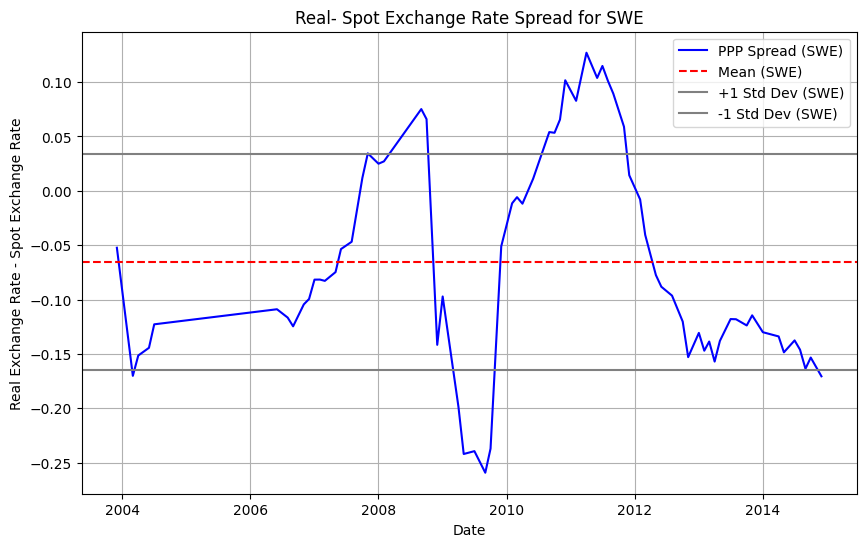

In [ ]:
# Convert exchange rates to a DataFrame
exchange_rates_df = pd.DataFrame({country: data.values.flatten() for country, data in exchange_rates_normalized.items()}, index=exchange_rates_normalized['CN'].index)
#index is added which was missing before

# Calculate PPP spread for each country
rer_spread = {}
for country in currency_pairs.keys():
    rer_spread[country] = exchange_rates_df[country]-(exchange_rates_df[country] * inflation_table_normalized[f'PPP {country}'])

# Convert PPP spread to a DataFrame
rer_spread_df = pd.DataFrame(rer_spread)

# Compute mean and standard deviation
rer_spread_mean = rer_spread_df.mean()
rer_spread_std = rer_spread_df.std()

# Plot the PPP spread for each country
for country in currency_pairs.keys():
    plt.figure(figsize=(10, 6))

    # Plot the original spread
    plt.plot(rer_spread_df.index, rer_spread_df[country], label=f'PPP Spread ({country})', color='blue')

    # Plot the mean
    plt.axhline(y=rer_spread_mean[country], color='red', linestyle='--', label=f'Mean ({country})')

    # Plot +/- 1 standard deviation
    plt.axhline(y=rer_spread_mean[country] + rer_spread_std[country], color='gray', linestyle='-', label=f'+1 Std Dev ({country})')
    plt.axhline(y=rer_spread_mean[country] - rer_spread_std[country], color='gray', linestyle='-', label=f'-1 Std Dev ({country})')

    plt.xlabel('Date')
    plt.ylabel('Real Exchange Rate - Spot Exchange Rate')
    plt.title(f'Real- Spot Exchange Rate Spread for {country}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for country in currency_pairs.keys():
    # Get the spread data for the current country
    spread_data = rer_spread_df[country]

    # Perform the ADF test
    result = adfuller(spread_data)

    # Print the results
    print(f"ADF Test Results for {country}:")
    print(f"  Test Statistic: {result[0]}")
    print(f"  p-value: {result[1]}")
    print(f"  Lags Used: {result[2]}")
    print(f"  Number of Observations Used: {result[3]}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")
    print("\n")

    # Interpretation based on p-value
    if result[1] <= 0.05:
        print(f"The spread for {country} is likely stationary (p-value <= 0.05).")
    else:
        print(f"The spread for {country} is likely non-stationary (p-value > 0.05).")
    print("-" * 30)

ADF Test Results for CN:
  Test Statistic: -3.5848487300720095
  p-value: 0.006057382142733368
  Lags Used: 5
  Number of Observations Used: 66
  Critical Values:
    1%: -3.5335601309235605
    5%: -2.9064436883991434
    10%: -2.590723948576676


The spread for CN is likely stationary (p-value <= 0.05).
------------------------------
ADF Test Results for KR:
  Test Statistic: -1.6536371995043977
  p-value: 0.4551442142868715
  Lags Used: 0
  Number of Observations Used: 71
  Critical Values:
    1%: -3.526004646825607
    5%: -2.9032002348069774
    10%: -2.5889948363419957


The spread for KR is likely non-stationary (p-value > 0.05).
------------------------------
ADF Test Results for BR:
  Test Statistic: -3.6577631425320725
  p-value: 0.004748038663048748
  Lags Used: 4
  Number of Observations Used: 67
  Critical Values:
    1%: -3.5319549603840894
    5%: -2.905755128523123
    10%: -2.5903569458676765


The spread for BR is likely stationary (p-value <= 0.05).
----------------

# Modified Spread

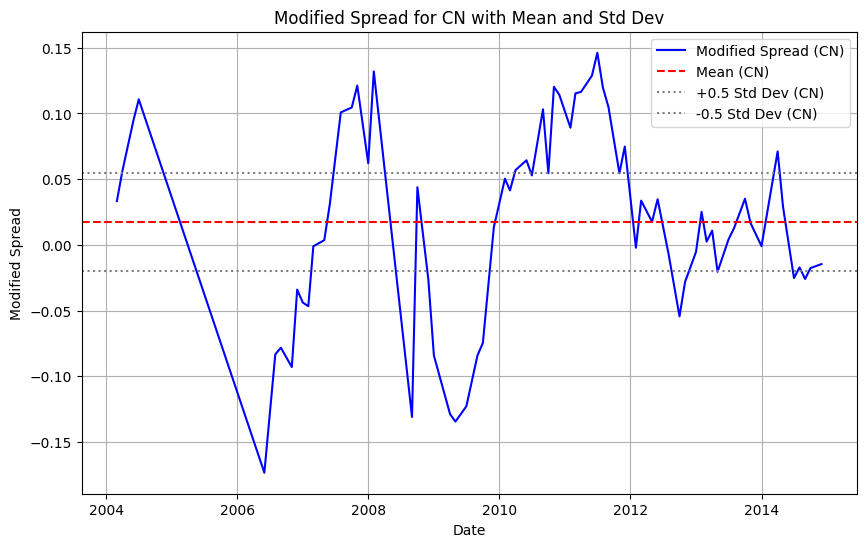

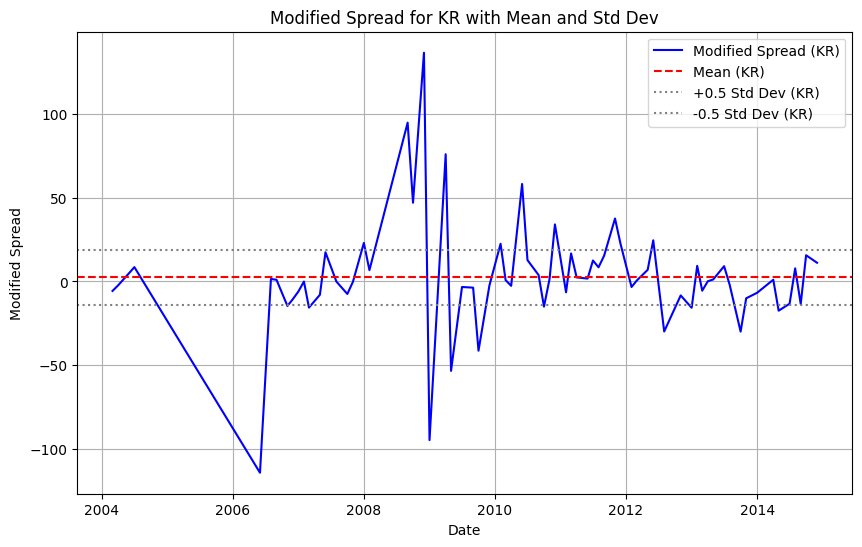

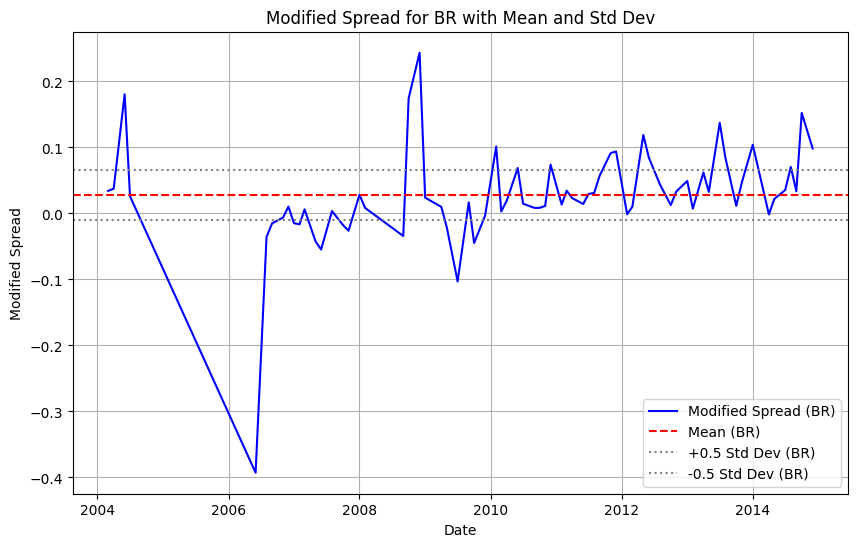

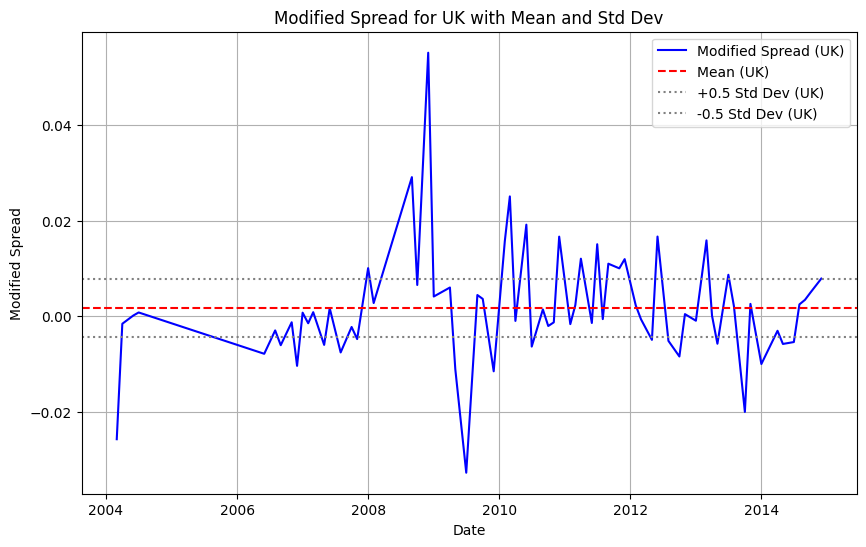

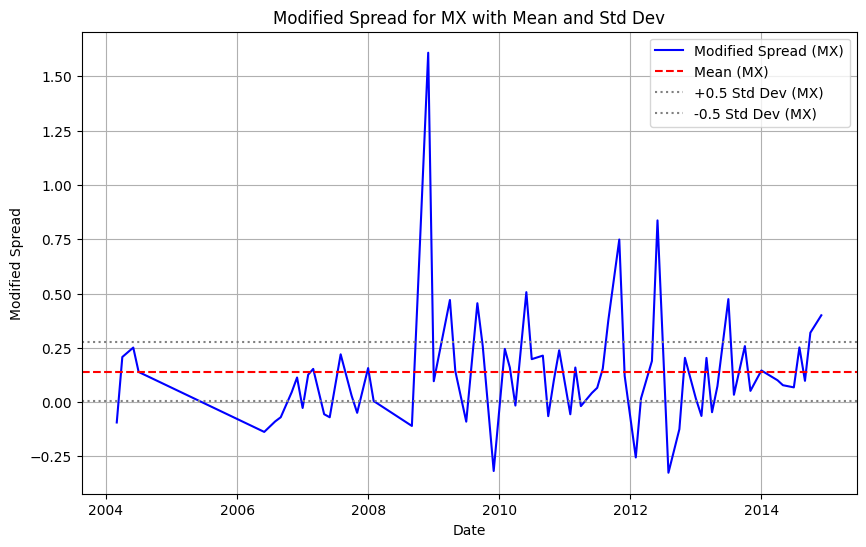

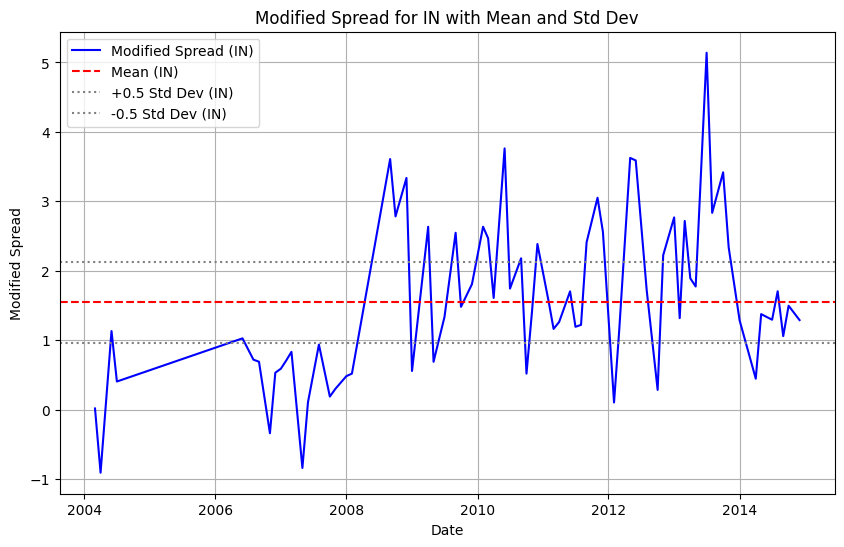

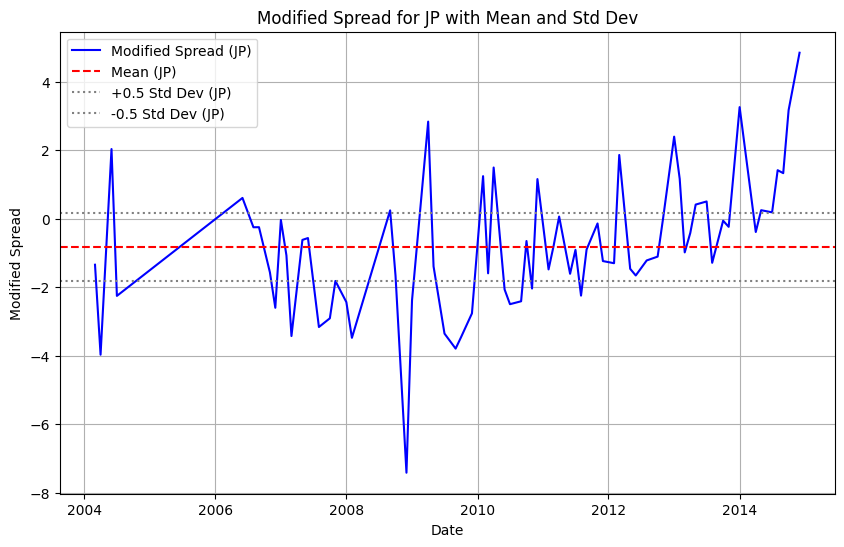

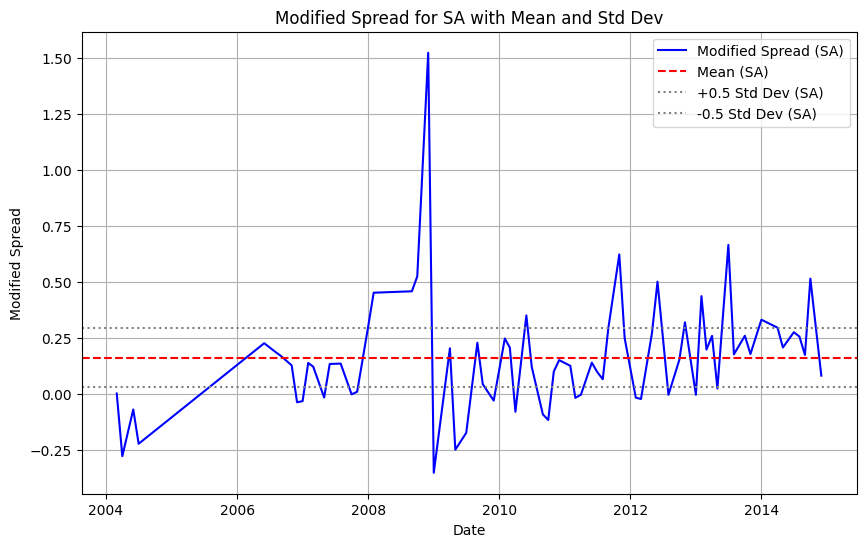

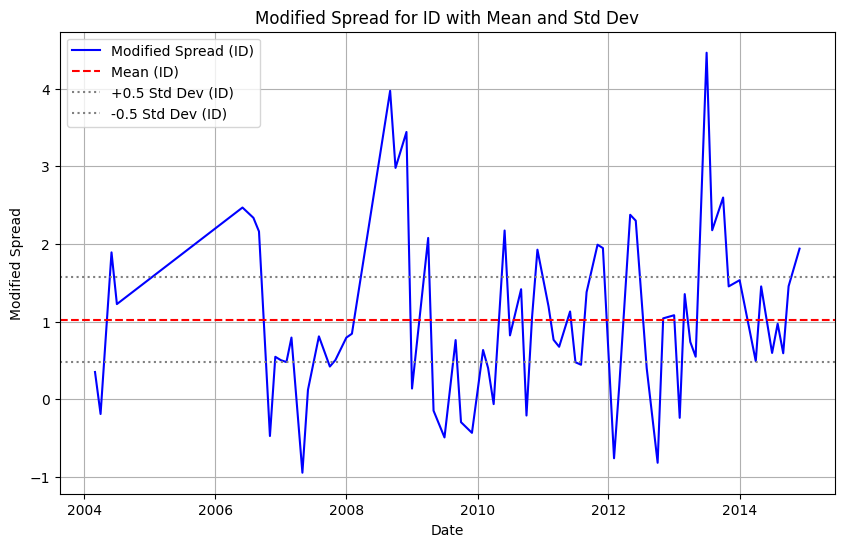

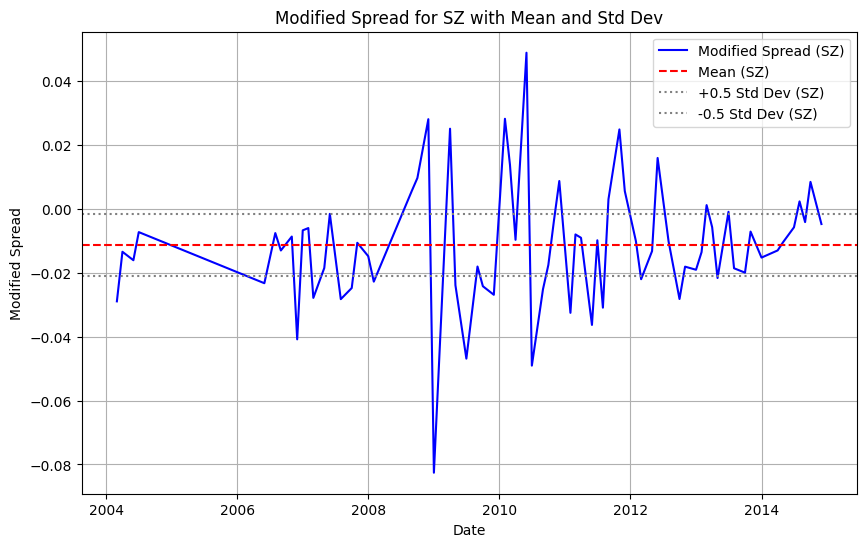

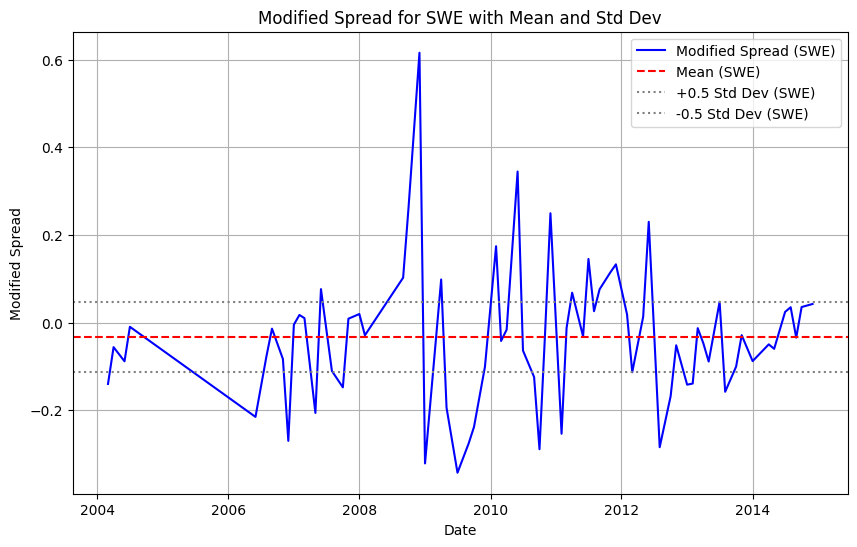

In [ ]:
# Calculate modified spread
modified_spread = {}
for country in currency_pairs.keys():
    # Shift the spot exchange rate by one period to get Spot(t-1)
    spot_lagged = exchange_rates_df[country].shift(1)

    # Calculate the real exchange rate (using your previous PPP calculation)
    real_exchange_rate = exchange_rates_df[country] * inflation_table_normalized[f'PPP {country}']

    # Calculate the modified spread
    modified_spread[country] = exchange_rates_df[country] - (0.5 * real_exchange_rate + 0.5 * spot_lagged)

# Convert modified spread to DataFrame
modified_spread_df = pd.DataFrame(modified_spread).dropna()

# Calculate mean and standard deviation
modified_spread_mean = modified_spread_df.mean()
modified_spread_std = modified_spread_df.std()

# Create a DataFrame to store the results
spread_stats_df = pd.DataFrame({
    'Mean': modified_spread_mean,
    'Std Dev': modified_spread_std
})

# Plot the modified spread with mean and +/- 1 standard deviation
for country in currency_pairs.keys():
    plt.figure(figsize=(10, 6))

    # Plot the modified spread
    plt.plot(modified_spread_df.index, modified_spread_df[country], label=f'Modified Spread ({country})', color='blue')

    # Plot the mean
    plt.axhline(y=modified_spread_mean[country], color='red', linestyle='--', label=f'Mean ({country})')

    # Plot +/- 1 standard deviation
    plt.axhline(y=modified_spread_mean[country] + (modified_spread_std[country]/2), color='gray', linestyle=':', label=f'+0.5 Std Dev ({country})')
    plt.axhline(y=modified_spread_mean[country] - (modified_spread_std[country]/2), color='gray', linestyle=':', label=f'-0.5 Std Dev ({country})')

    plt.xlabel('Date')
    plt.ylabel('Modified Spread')
    plt.title(f'Modified Spread for {country} with Mean and Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Perform ADF test for each country's modified spread
for country in currency_pairs.keys():
    # Get the modified spread data for the current country
    modified_spread_data = modified_spread_df[country]

    # Perform the ADF test
    result = adfuller(modified_spread_data)

    # Print the results
    print(f"ADF Test Results for Modified Spread ({country}):")
    print(f"  Test Statistic: {result[0]}")
    print(f"  p-value: {result[1]}")
    print(f"  Lags Used: {result[2]}")
    print(f"  Number of Observations Used: {result[3]}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")
    print("\n")

    # Interpretation based on p-value
    if result[1] <= 0.05:
        print(f"The modified spread for {country} is likely stationary (p-value <= 0.05).")
    else:
        print(f"The modified spread for {country} is likely non-stationary (p-value > 0.05).")
    print("-" * 30)  # Separator line

ADF Test Results for Modified Spread (CN):
  Test Statistic: -2.5570670091325267
  p-value: 0.10219920390476073
  Lags Used: 1
  Number of Observations Used: 69
  Critical Values:
    1%: -3.528889992207215
    5%: -2.9044395987933362
    10%: -2.589655654274312


The modified spread for CN is likely non-stationary (p-value > 0.05).
------------------------------
ADF Test Results for Modified Spread (KR):
  Test Statistic: -4.447059216203843
  p-value: 0.0002448014388259202
  Lags Used: 1
  Number of Observations Used: 69
  Critical Values:
    1%: -3.528889992207215
    5%: -2.9044395987933362
    10%: -2.589655654274312


The modified spread for KR is likely stationary (p-value <= 0.05).
------------------------------
ADF Test Results for Modified Spread (BR):
  Test Statistic: -4.023969698477389
  p-value: 0.001290070874260421
  Lags Used: 3
  Number of Observations Used: 67
  Critical Values:
    1%: -3.5319549603840894
    5%: -2.905755128523123
    10%: -2.5903569458676765


The 

# Backtest Area

In [ ]:
# Define data series IDs and backtest start/end dates
series_id_inflaton_BT = {
    'Inflation USA': 'CORESTICKM159SFRBATL'}

series_ids_CPI_BT = {
    'Inflation CN BT': 'CHNCPIALLMINMEI',
    'Inflation KR BT': 'KORCPIALLMINMEI',
    'Inflation BR BT': 'BRACPIALLMINMEI',
    'Inflation UK BT': 'GBRCPIALLMINMEI',
    'Inflation MX BT': 'MEXCPIALLMINMEI',
    'Inflation IN BT': 'INDCPIALLMINMEI',
    'Inflation JP BT': 'JPNCPIALLMINMEI',
    'Inflation SA BT': 'ZAFCPIALLMINMEI',
    'Inflation ID BT': 'IDNCPIALLMINMEI',
    'Inflation SZ BT': 'CHECPIALLMINMEI',
    'Inflation SWE BT': 'SWECPIALLMINMEI'
    }

start_date_bt = '2015-01-02'  # 10 years horizon
end_date_bt = '2024-01-02'

In [ ]:
# Define functions to find the optimal weights for each country
def calculate_modified_spread(country, w):
    """Calculates the modified spread for a given country and weight w."""
    spot_lagged = exchange_rates_df[country].shift(1)
    real_exchange_rate = exchange_rates_df[country] * inflation_table_normalized[f'PPP {country}']
    modified_spread = exchange_rates_df[country] - (w * real_exchange_rate + (1 - w) * spot_lagged)
    return modified_spread

def find_optimal_w(country):
    """Finds the optimal w that maximizes stationarity for the modified spread."""
    best_w = 0
    min_p_value = 1  # Initialize with a high p-value

    for w in np.linspace(0, 1, 51):  # Test 51 values between 0 and 1
        modified_spread = calculate_modified_spread(country, w).dropna()
        result = adfuller(modified_spread)
        p_value = result[1]

        if p_value < min_p_value:
            min_p_value = p_value
            best_w = w

    return best_w

# Find and store optimal w for each country
optimal_weights = {country: find_optimal_w(country) for country in currency_pairs.keys()}

# Print optimal weights
for country, w in optimal_weights.items():
    print(f"Optimal w for {country}: {w}")

# Fetch exchange rate data for backtest period
exchange_rates_bt = {}
for country, pair in currency_pairs.items():
    data = yf.download(pair, start=start_date_bt, end=end_date_bt)['Close']
    if np.isscalar(data):
        data = pd.Series(data, index=[pd.to_datetime(start_date_bt)])
    elif len(data) == 0:
        data = pd.Series(np.nan, index=pd.date_range(start=start_date_bt, end=end_date_bt, freq='D'))
    data = data.reindex(pd.date_range(start=start_date_bt, end=end_date_bt, freq='D'))
    exchange_rates_bt[country] = data.values.flatten()

exchange_rates_bt_df = pd.DataFrame(exchange_rates_bt, index=pd.date_range(start=start_date_bt, end=end_date_bt, freq='D'))

# Get CPI data from FRED
cpi_data_bt = pd.DataFrame()
for country, series_id in series_ids_CPI_BT.items():
    data = fred.get_series(series_id, observation_start=start_date_bt, observation_end=end_date_bt)
    cpi_data_bt[country] = data

# Calculate inflation rate using log difference
inflation_data_bt = (np.log(cpi_data_bt) - np.log(cpi_data_bt.shift(12))).dropna() * 100

# Fetch inflation data for US
inflation_rates_bt = pd.DataFrame()
for country, series_id in series_id_inflaton_BT.items():
    data = fred.get_series(series_id, observation_start=start_date_bt, observation_end=end_date_bt)
    inflation_rates_bt[country] = data

# Align inflation_rates_bt and inflation_data_bt indices
inflation_rates_bt = inflation_rates_bt.reindex(inflation_data_bt.index)

# Combine the dataframes
inflation_table_bt = pd.concat([inflation_rates_bt, inflation_data_bt], axis=1)

# Calculate PPP
for country in currency_pairs.keys():
    inflation_table_bt[f'PPP {country}'] = (1 + inflation_table_bt['Inflation USA'] / 100) / (1 + inflation_table_bt[f'Inflation {country} BT'] / 100)

# Calculate modified spread for backtest period
modified_spread_bt = {}
for country in currency_pairs.keys():
    exchange_rates_bt_df_reindexed = exchange_rates_bt_df.reindex(inflation_table_bt.index)
    spot_lagged_bt = exchange_rates_bt_df_reindexed[country].shift(1)
    real_exchange_rate_bt = exchange_rates_bt_df_reindexed[country] * inflation_table_bt[f'PPP {country}']
    modified_spread_bt[country] = exchange_rates_bt_df_reindexed[country] - (optimal_weights[country] * real_exchange_rate_bt + (1 - optimal_weights[country]) * spot_lagged_bt)

modified_spread_bt_df = pd.DataFrame(modified_spread_bt).dropna()

[*********************100%***********************]  1 of 1 completed

Optimal w for CN: 0.12
Optimal w for KR: 0.0
Optimal w for BR: 0.0
Optimal w for UK: 0.32
Optimal w for MX: 0.0
Optimal w for IN: 0.0
Optimal w for JP: 0.0
Optimal w for SA: 0.0
Optimal w for ID: 0.0
Optimal w for SZ: 0.22
Optimal w for SWE: 0.0



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Backtesting Logic with Separate Long/Short Returns
returns = {country: [] for country in currency_pairs.keys()}
win_rates = {}
trades = pd.DataFrame(columns=['Country', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Return'])  # Create an empty DataFrame
k = 0.1 # Standard deviation multiple for trading signal

for country in currency_pairs.keys():
    position = 0  # 0: no position, 1: long USD/short foreign, -1: short USD/long foreign
    entry_price = None
    entry_date = None  # Store entry date

    common_index = modified_spread_bt_df.index.intersection(exchange_rates_bt_df.index)
    modified_spread_bt_df_aligned = modified_spread_bt_df.loc[common_index]
    exchange_rates_bt_df_aligned = exchange_rates_bt_df.loc[common_index]

    for i in range(1, len(modified_spread_bt_df_aligned)):
        spread = modified_spread_bt_df_aligned[country].iloc[i]
        mean = spread_stats_df.loc[country, 'Mean']
        std_dev = spread_stats_df.loc[country, 'Std Dev']

        if position == 0:
            if spread <= mean - (k * std_dev):  # Long USD, Short Foreign
                position = 1
                entry_price = exchange_rates_bt_df_aligned[country].iloc[i]
                entry_date = modified_spread_bt_df_aligned.index[i]  # Record entry date
            elif spread >= mean + (k * std_dev):  # Long Foreign, Short USD
                position = -1
                entry_price = exchange_rates_bt_df_aligned[country].iloc[i]
                entry_date = modified_spread_bt_df_aligned.index[i]  # Record entry date
        elif position == 1 and spread >= mean:  # Exit long position
            position = 0
            exit_price = exchange_rates_bt_df_aligned[country].iloc[i]
            trade_return = (exit_price - entry_price) / entry_price
            returns[country].append(trade_return)
            trades = pd.concat([trades, pd.DataFrame([{  # Append to trades DataFrame
                'Country': country,
                'Entry Date': entry_date,
                'Exit Date': modified_spread_bt_df_aligned.index[i],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'Return': trade_return
            }])], ignore_index=True)
            entry_price = None
            entry_date = None  # Reset entry date
        elif position == -1 and spread <= mean:  # Exit short position
            position = 0
            exit_price = exchange_rates_bt_df_aligned[country].iloc[i]
            trade_return = (entry_price - exit_price) / entry_price
            returns[country].append(trade_return)
            trades = pd.concat([trades, pd.DataFrame([{  # Append to trades DataFrame
                'Country': country,
                'Entry Date': entry_date,
                'Exit Date': modified_spread_bt_df_aligned.index[i],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'Return': trade_return
            }])], ignore_index=True)
            entry_price = None
            entry_date = None  # Reset entry date

# Analyze Backtest Results (Combined Long/Short)
total_portfolio_return = {}  # Store total returns for each country
for country in currency_pairs.keys():
    total_portfolio_return[country] = (1 + np.array(returns[country])).prod() - 1
    win_rates[country] = sum(1 for r in returns[country] if r > 0) / len(returns[country]) if len(returns[country]) > 0 else 0

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Country Name': list(currency_pairs.keys()),
    'Portfolio Return': [f"{ret:.2%}" for ret in total_portfolio_return.values()],
    'Win Rate': [f"{wr:.2%}"for wr in win_rates.values()]
})

# Sort trades by Entry Date
trades = trades.sort_values(by=['Entry Date'])

print(results_df)

average_return = np.mean(list(total_portfolio_return.values()))
print(f"\nAverage Return Over All Currencies: {average_return:.2%}")

average_win_rate = np.mean(list(win_rates.values()))
print(f"Average Win Rate Over All Currencies: {average_win_rate:.2%}")  # Print average win rate

trades = trades.sort_values(by=['Entry Date'])
print(trades)

   Country Name Portfolio Return Win Rate
0            CN          -15.05%   62.50%
1            KR           -5.52%   44.44%
2            BR           48.95%   90.91%
3            UK           26.08%   63.64%
4            MX           80.23%   80.00%
5            IN            8.01%   66.67%
6            JP            1.99%   66.67%
7            SA           -9.10%   37.50%
8            ID            2.65%   66.67%
9            SZ           -0.24%   42.86%
10          SWE           -6.65%   57.14%

Average Return Over All Currencies: 11.94%
Average Win Rate Over All Currencies: 61.73%
   Country Entry Date  Exit Date  Entry Price   Exit Price    Return
0       CN 2016-03-01 2016-07-01     6.544000     6.638100  0.014380
69      SZ 2016-03-01 2016-09-01     0.997700     0.983570 -0.014163
8       KR 2016-03-01 2016-04-01  1236.199951  1140.800049  0.077172
66      ID 2016-03-01 2016-12-01    68.218002    68.587997  0.005424
58      SA 2016-03-01 2016-09-01    15.840280    14.679300 -0.

<ipython-input-14-cbb77ebaef5c>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trades = pd.concat([trades, pd.DataFrame([{  # Append to trades DataFrame


# Tracking and Smoothing Strategy

In [ ]:
# Function to perform the backtest with given parameters
def backtest_with_params(country, w, alpha, k, start_date='1999-01-01', end_date='2015-01-01'):
    """
    Runs a backtest for a given country using specified parameters (w, alpha, k).
    Returns the total portfolio return for the specified date range.
    """
    # Function to calculate the modified spread with smoothing
    def calculate_modified_spread_with_smoothing_bt(country, w, alpha, exchange_rates_bt_df, inflation_table_bt):
        """
        Calculates the modified spread using smoothed real exchange rate and lagged exchange rate for backtesting.
        """
        # Align exchange rates and inflation data
        exchange_rates_bt_df_reindexed = exchange_rates_bt_df.reindex(inflation_table_bt.index)
        spot_lagged_bt = exchange_rates_bt_df_reindexed[country].shift(1)
        real_exchange_rate_bt = exchange_rates_bt_df_reindexed[country] * inflation_table_bt[f'PPP {country}']

        # Apply exponential smoothing to the real exchange rate
        smoothed_real_exchange_rate_bt = real_exchange_rate_bt.ewm(alpha=alpha).mean()

        # Calculate modified spread using smoothed real exchange rate and lagged exchange rate
        modified_spread_bt = exchange_rates_bt_df_reindexed[country] - (
            w * smoothed_real_exchange_rate_bt + (1 - w) * spot_lagged_bt
        )
        return modified_spread_bt

    # Filter data for the given date range
    exchange_rates_filtered = exchange_rates_df.loc[start_date:end_date]
    inflation_table_filtered = inflation_table.loc[start_date:end_date]

    # Calculate the modified spread with smoothing
    modified_spread = calculate_modified_spread_with_smoothing_bt(
        country, w, alpha, exchange_rates_filtered, inflation_table_filtered
    ).dropna()

    # Align modified spread and exchange rates
    common_index = modified_spread.index.intersection(exchange_rates_filtered.index)
    modified_spread_aligned = modified_spread.loc[common_index]
    exchange_rates_df_aligned = exchange_rates_filtered.loc[common_index]

    position = 0  # 0: no position, 1: long USD/short foreign, -1: short USD/long foreign
    entry_price = None
    total_returns = []

    # Backtesting loop
    for i in range(1, len(modified_spread_aligned)):
        spread = modified_spread_aligned.iloc[i]
        mean = modified_spread_aligned.mean()  # Use the in-sample mean
        std_dev = modified_spread_aligned.std()  # Use the in-sample standard deviation

        if position == 0:
            if spread <= mean - (k * std_dev):  # Long USD, Short Foreign
                position = 1
                entry_price = exchange_rates_df_aligned[country].iloc[i]
            elif spread >= mean + (k * std_dev):  # Long Foreign, Short USD
                position = -1
                entry_price = exchange_rates_df_aligned[country].iloc[i]
        elif position == 1 and spread >= mean:  # Exit long position
            position = 0
            exit_price = exchange_rates_df_aligned[country].iloc[i]
            trade_return = (exit_price - entry_price) / entry_price
            total_returns.append(trade_return)
            entry_price = None
        elif position == -1 and spread <= mean:  # Exit short position
            position = 0
            exit_price = exchange_rates_df_aligned[country].iloc[i]
            trade_return = (entry_price - exit_price) / entry_price
            total_returns.append(trade_return)
            entry_price = None

    # Calculate total portfolio return
    if len(total_returns) > 0:
        portfolio_return = (1 + np.array(total_returns)).prod() - 1
    else:
        portfolio_return = 0

    return portfolio_return

Parameter Optimization via Grid Search

In [ ]:
# Define the backtest function for parameter evaluation
def backtest_with_params(country, w, alpha, k, start_date='1999-01-01', end_date='2015-01-01'):
    """
    Runs a backtest for a given country using specified parameters (w, alpha, k).
    Returns the total portfolio return for the specified date range.
    """
    # Filter data for the given date range
    exchange_rates_filtered = exchange_rates_df.loc[start_date:end_date]
    inflation_table_filtered = inflation_table.loc[start_date:end_date]

    # Calculate the modified spread with smoothing
    modified_spread = calculate_modified_spread_with_smoothing_bt(
        country, w, alpha, exchange_rates_filtered, inflation_table_filtered
    ).dropna()

    # Align modified spread and exchange rates
    common_index = modified_spread.index.intersection(exchange_rates_filtered.index)
    modified_spread_aligned = modified_spread.loc[common_index]
    exchange_rates_df_aligned = exchange_rates_filtered.loc[common_index]

    position = 0  # 0: no position, 1: long USD/short foreign, -1: short USD/long foreign
    entry_price = None
    total_returns = []

    # Backtesting loop
    for i in range(1, len(modified_spread_aligned)):
        spread = modified_spread_aligned.iloc[i]
        mean = modified_spread_aligned.mean()  # Use the in-sample mean
        std_dev = modified_spread_aligned.std()  # Use the in-sample standard deviation

        if position == 0:
            if spread <= mean - (k * std_dev):  # Long USD, Short Foreign
                position = 1
                entry_price = exchange_rates_df_aligned[country].iloc[i]
            elif spread >= mean + (k * std_dev):  # Long Foreign, Short USD
                position = -1
                entry_price = exchange_rates_df_aligned[country].iloc[i]
        elif position == 1 and spread >= mean:  # Exit long position
            position = 0
            exit_price = exchange_rates_df_aligned[country].iloc[i]
            trade_return = (exit_price - entry_price) / entry_price
            total_returns.append(trade_return)
            entry_price = None
        elif position == -1 and spread <= mean:  # Exit short position
            position = 0
            exit_price = exchange_rates_df_aligned[country].iloc[i]
            trade_return = (entry_price - exit_price) / entry_price
            total_returns.append(trade_return)
            entry_price = None

    # Calculate total portfolio return
    if len(total_returns) > 0:
        portfolio_return = (1 + np.array(total_returns)).prod() - 1
    else:
        portfolio_return = 0

    return portfolio_return


# Optimization Function
def objective(params, country):
    """
    Objective function to optimize (negative total return).
    params: [w, alpha, k]
    """
    w, alpha, k = params
    # Restrict parameter ranges
    if not (0 <= w <= 1 and 0.01 <= alpha <= 0.5 and 0.05 <= k <= 0.5):
        return 1e6  # Penalize invalid parameter combinations
    return -backtest_with_params(country, w, alpha, k, start_date='1999-01-01', end_date='2015-01-01')

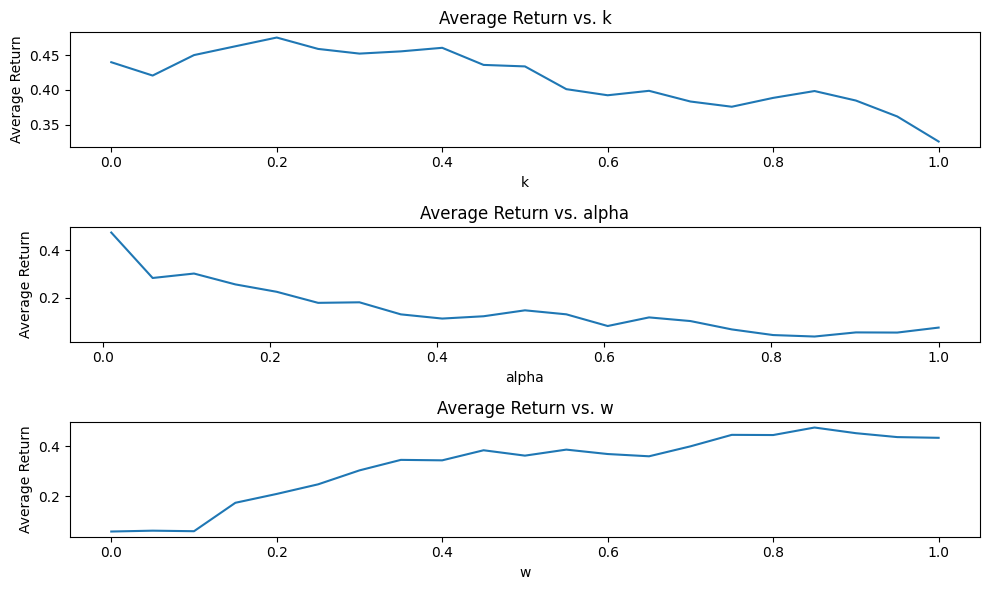

In [ ]:
# Function to calculate the modified spread with smoothing
def calculate_modified_spread_with_smoothing_bt(country, w, alpha, exchange_rates_bt_df, inflation_table_bt):
    """
    Calculates the modified spread using smoothed real exchange rate and lagged exchange rate for backtesting.
    """
    # Align exchange rates and inflation data
    exchange_rates_bt_df_reindexed = exchange_rates_bt_df.reindex(inflation_table_bt.index)
    spot_lagged_bt = exchange_rates_bt_df_reindexed[country].shift(1)
    real_exchange_rate_bt = exchange_rates_bt_df_reindexed[country] * inflation_table_bt[f'PPP {country}']

    # Apply exponential smoothing to the real exchange rate
    smoothed_real_exchange_rate_bt = real_exchange_rate_bt.ewm(alpha=alpha).mean()

    # Calculate modified spread using smoothed real exchange rate and lagged exchange rate
    modified_spread_bt = exchange_rates_bt_df_reindexed[country] - (
        w * smoothed_real_exchange_rate_bt + (1 - w) * spot_lagged_bt
    )
    return modified_spread_bt

# Define constants for the other parameters while varying one
constant_k = 0.2
constant_alpha = 0.01
constant_w = 0.85

# Define parameter ranges
k_values = np.linspace(0, 1, 21)
alpha_values = np.linspace(0.01, 1, 21)
w_values = np.linspace(0, 1, 21)

# Store average returns for each parameter
average_returns_k = []
average_returns_alpha = []
average_returns_w = []
country_count = 0

# Loop through parameter values and calculate average returns
for k in k_values:
    total_return = 0
    country_count = 0
    for country in currency_pairs.keys():
        # Perform backtest for the current k, with constant alpha and w
        portfolio_return = backtest_with_params(country, w=constant_w, alpha=constant_alpha, k=k)
        total_return += portfolio_return
        country_count += 1
    # Store the average return for the current k
    average_returns_k.append(total_return / country_count)

for alpha in alpha_values:
    total_return = 0
    country_count = 0
    for country in currency_pairs.keys():
        # Perform backtest for the current alpha, with constant k and w
        portfolio_return = backtest_with_params(country, w=constant_w, alpha=alpha, k=constant_k)
        total_return += portfolio_return
        country_count += 1
    # Store the average return for the current alpha
    average_returns_alpha.append(total_return / country_count)

for w in w_values:
    total_return = 0
    country_count = 0
    for country in currency_pairs.keys():
        # Perform backtest for the current w, with constant k and alpha
        portfolio_return = backtest_with_params(country, w=w, alpha=constant_alpha, k=constant_k)
        total_return += portfolio_return
        country_count += 1
    # Store the average return for the current w
    average_returns_w.append(total_return / country_count)

# Create plots
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(k_values, average_returns_k)
plt.xlabel('k')
plt.ylabel('Average Return')
plt.title('Average Return vs. k')

plt.subplot(3, 1, 2)
plt.plot(alpha_values, average_returns_alpha)
plt.xlabel('alpha')
plt.ylabel('Average Return')
plt.title('Average Return vs. alpha')

plt.subplot(3, 1, 3)
plt.plot(w_values, average_returns_w)
plt.xlabel('w')
plt.ylabel('Average Return')
plt.title('Average Return vs. w')

plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate the modified spread with smoothing
def calculate_modified_spread_with_smoothing_bt(country, w, alpha, exchange_rates_bt_df, inflation_table_bt):
    """
    Calculates the modified spread using smoothed real exchange rate and lagged exchange rate for backtesting.
    """
    # Align exchange rates and inflation data
    exchange_rates_bt_df_reindexed = exchange_rates_bt_df.reindex(inflation_table_bt.index)
    spot_lagged_bt = exchange_rates_bt_df_reindexed[country].shift(1)
    real_exchange_rate_bt = exchange_rates_bt_df_reindexed[country] * inflation_table_bt[f'PPP {country}']

    # Apply exponential smoothing to the real exchange rate
    smoothed_real_exchange_rate_bt = real_exchange_rate_bt.ewm(alpha=alpha).mean()

    # Calculate modified spread using smoothed real exchange rate and lagged exchange rate
    modified_spread_bt = exchange_rates_bt_df_reindexed[country] - (
        w * smoothed_real_exchange_rate_bt + (1 - w) * spot_lagged_bt
    )
    return modified_spread_bt

# Define parameter ranges
k_values = np.linspace(0, 1, 21)
alpha_values = np.linspace(0.01, 1, 21)
w_values = np.linspace(0, 1, 21)

# Store the best combination and its return
best_return = -np.inf
best_params = (None, None, None)

# Grid search
for k in k_values:
    for alpha in alpha_values:
        for w in w_values:
            total_return = 0
            country_count = 0
            for country in currency_pairs.keys():
                portfolio_return = backtest_with_params(country, w=w, alpha=alpha, k=k)
                total_return += portfolio_return
                country_count += 1
            average_return = total_return / country_count

            # Update best parameters if current combination is better
            if average_return > best_return:
                best_return = average_return
                best_params = (k, alpha, w)

print(f"Best parameters: k={best_params[0]}, alpha={best_params[1]}, w={best_params[2]}")
print(f"Best average return: {best_return}")

KeyboardInterrupt: 

<ipython-input-20-04ba30e324e8>:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trades = pd.concat([trades, pd.DataFrame([{


   Country Name Portfolio Return Win Rate  Total Trades
0            CN            9.87%  100.00%             5
1            KR           13.84%   75.00%             4
2            BR           46.19%  100.00%             4
3            UK           18.39%   83.33%             6
4            MX           17.55%  100.00%             4
5            IN           11.92%  100.00%             4
6            JP            9.08%  100.00%             4
7            SA           17.85%   60.00%             5
8            ID            7.04%  100.00%             3
9            SZ            6.92%  100.00%             3
10          SWE           30.46%  100.00%             4

Average Return Over All Currencies: 17.19%
Average Win Rate Over All Currencies: 92.58%
   Country Entry Date  Exit Date Position  Entry Price   Exit Price    Return
0       CN 2016-03-01 2016-07-01     Long     6.544000     6.638100  0.014380
27      JP 2016-03-01 2016-12-01     Long   112.430000   114.694000  0.020137
23   

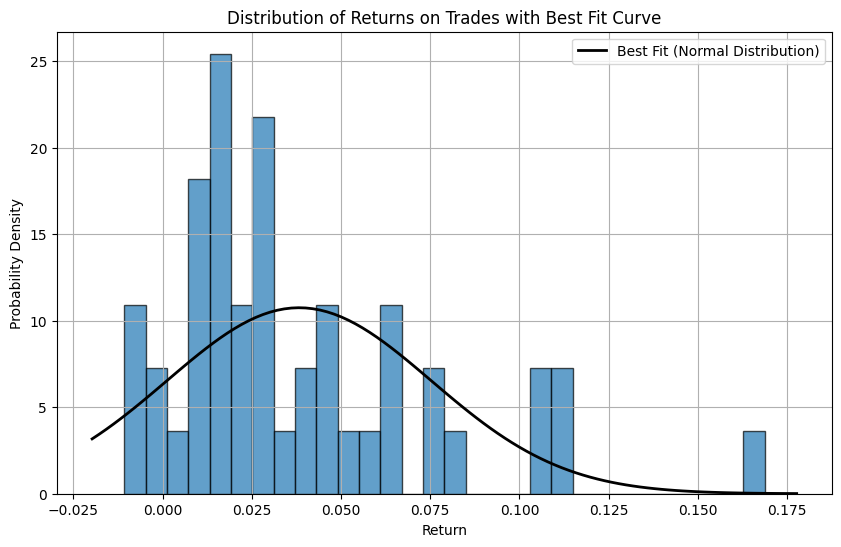

In [ ]:
# Backtesting Logic with the New Weighting Strategy
returns = {country: [] for country in currency_pairs.keys()}
win_rates = {}
trades = pd.DataFrame(columns=['Country', 'Entry Date', 'Exit Date','Position', 'Entry Price', 'Exit Price', 'Return'])
# Create an empty DataFrame
k = 0.2   # Standard deviation multiple for trading signal
alpha = 0.01  # Smoothing factor
w = 0.85  # Weight for smoothed real exchange rate

for country in currency_pairs.keys():
    position = 0  # 0: no position, 1: long USD/short foreign, -1: short USD/long foreign
    entry_price = None
    entry_date = None

    # Calculate modified spread with smoothing
    modified_spread_bt = calculate_modified_spread_with_smoothing_bt(
        country, w, alpha, exchange_rates_bt_df, inflation_table_bt
    ).dropna()

    # Align modified spread and exchange rates
    common_index = modified_spread_bt.index.intersection(exchange_rates_bt_df.index)
    modified_spread_bt_aligned = modified_spread_bt.loc[common_index]
    exchange_rates_bt_df_aligned = exchange_rates_bt_df.loc[common_index]

    for i in range(1, len(modified_spread_bt_aligned)):
        spread = modified_spread_bt_aligned.iloc[i]
        mean = spread_stats_df.loc[country, 'Mean']
        std_dev = spread_stats_df.loc[country, 'Std Dev']

        if position == 0:
            if spread <= mean - (k * std_dev):  # Long USD, Short Foreign
                position = 1
                entry_price = exchange_rates_bt_df_aligned[country].iloc[i]
                entry_date = modified_spread_bt_aligned.index[i]
                position_type = 'Long'
            elif spread >= mean + (k * std_dev):  # Long Foreign, Short USD
                position = -1
                entry_price = exchange_rates_bt_df_aligned[country].iloc[i]
                entry_date = modified_spread_bt_aligned.index[i]  # Record entry date
                position_type = 'Short'
        elif position == 1 and spread >= mean:  # Exit long position
            position = 0
            exit_price = exchange_rates_bt_df_aligned[country].iloc[i]
            trade_return = (exit_price - entry_price) / entry_price
            returns[country].append(trade_return)
            trades = pd.concat([trades, pd.DataFrame([{
                'Country': country,
                'Entry Date': entry_date,
                'Position': position_type,
                'Exit Date': modified_spread_bt_aligned.index[i],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'Return': trade_return
            }])], ignore_index=True)
            entry_price = None
            entry_date = None  # Reset entry date
        elif position == -1 and spread <= mean:  # Exit short position
            position = 0
            exit_price = exchange_rates_bt_df_aligned[country].iloc[i]
            trade_return = (entry_price - exit_price) / entry_price
            returns[country].append(trade_return)
            trades = pd.concat([trades, pd.DataFrame([{
                'Country': country,
                'Entry Date': entry_date,
                'Position': position_type,
                'Exit Date': modified_spread_bt_aligned.index[i],
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'Return': trade_return
            }])], ignore_index=True)
            entry_price = None
            entry_date = None  # Reset entry date

# Analyze Backtest Results (Combined Long/Short)
total_portfolio_return = {}
trade_counts = {}
win_rates = {}
for country in currency_pairs.keys():
    total_portfolio_return[country] = (1 + np.array(returns[country])).prod() - 1
    win_rates[country] = sum(1 for r in returns[country] if r > 0) / len(returns[country]) if len(returns[country]) > 0 else 0
    trade_counts[country] = len(returns[country])

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Country Name': list(currency_pairs.keys()),
    'Portfolio Return': [f"{ret:.2%}" for ret in total_portfolio_return.values()],
    'Win Rate': [f"{wr:.2%}"for wr in win_rates.values()],
    'Total Trades': list(trade_counts.values())
})

# Sort trades by Entry Date
trades = trades.sort_values(by=['Entry Date'])

print(results_df)

average_return = np.mean(list(total_portfolio_return.values()))
print(f"\nAverage Return Over All Currencies: {average_return:.2%}")

average_win_rate = np.mean(list(win_rates.values()))
print(f"Average Win Rate Over All Currencies: {average_win_rate:.2%}")  # Print average win

print(trades)

# Plot Distribution of Returns with Best Fit Curve
plt.figure(figsize=(10, 6))
plt.hist(trades['Return'], bins=30, density=True, edgecolor='black', alpha=0.7)

# Fit a normal distribution to the data
mu, std = stats.norm.fit(trades['Return'].dropna())  # Fit to non-NaN values
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

# Plot the best fit curve
plt.plot(x, p, 'k', linewidth=2, label='Best Fit (Normal Distribution)')

plt.title('Distribution of Returns on Trades with Best Fit Curve')
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()